# Install TODS

In [1]:
import warnings
warnings.filterwarnings("ignore")

!pip install -e git+https://github.com/datamllab/tods.git@dev#egg=tods 

Obtaining tods from git+https://github.com/datamllab/tods.git@dev#egg=tods
  Updating ./src/tods clone (to revision dev)
  Running command git fetch -q --tags
  Running command git reset --hard -q feb0c9c48b750c1dc4b9d60b5884b93d7824e77b
  Preparing metadata (setup.py) ... done
  Attempting uninstall: tods
    Found existing installation: tods 0.0.2
    Uninstalling tods-0.0.2:
      Successfully uninstalled tods-0.0.2
  DEPRECATION: Legacy editable install of tods from git+https://github.com/datamllab/tods.git@dev#egg=tods (setup.py develop) is deprecated. pip 25.0 will enforce this behaviour change. A possible replacement is to add a pyproject.toml or enable --use-pep517, and use setuptools >= 64. If the resulting installation is not behaving as expected, try using --config-settings editable_mode=compat. Please consult the setuptools documentation for more information. Discussion can be found at https://github.com/pypa/pip/issues/11457
  Running setup.py develop for tods


In [1]:
import numpy as np
import os
import glob
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.datasets import fetch_covtype
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from scipy.io import arff
import sklearn as sk
import time
from sklearn.datasets import fetch_openml

from tods.sk_interface.detection_algorithm.OCSVM_skinterface import OCSVMSKI
from tods.sk_interface.detection_algorithm.KNN_skinterface import KNNSKI

2024-09-27 19:30:31.204891: W tensorflow/stream_executor/platform/default/dso_loader.cc:60] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2024-09-27 19:30:31.204925: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [58]:
# df = pd.read_csv('./Data/multivariate/Occupancy/room-occupancy-0.test.csv')
df = pd.read_csv('./Data/multivariate/Daphnet/S01R01E1.test.csv')
df.drop(["timestamp"], axis = 1, inplace = True)
df.head()

,ankle_horiz_fwd,ankle_vert,ankle_horiz_lateral,leg_horiz_fwd,leg_vert,leg_horiz_lateral,trunk_horiz_fwd,trunk_vert,trunk_horiz_lateral,is_anomaly
0,-121,960,366,-254,944,222,-58,1028,38,0
1,-80,970,346,-209,935,191,-38,1000,19,0
2,-80,990,336,-145,935,191,-29,1000,9,0
3,-80,990,346,-154,962,181,-38,1019,38,0
4,-80,990,346,-172,981,181,-48,1028,48,0


In [59]:
print(df.columns[:-1]) #feature_names

Index(['ankle_horiz_fwd', 'ankle_vert', 'ankle_horiz_lateral', 'leg_horiz_fwd',
       'leg_vert', 'leg_horiz_lateral', 'trunk_horiz_fwd', 'trunk_vert',
       'trunk_horiz_lateral'],
      dtype='object')


In [60]:
def remove_files_from_directory(directory):
    # Get all files in the directory
    files = glob.glob(os.path.join(directory, "*"))
    
    # Loop through the files and remove each one
    for file in files:
        if os.path.isfile(file):
            os.remove(file)
    
    print(f"All files in {directory} have been removed.")

In [61]:
feature_folder = 'features'
remove_files_from_directory(feature_folder)
os.makedirs(feature_folder, exist_ok=True)

All files in features have been removed.


In [62]:
X = df.iloc[:, :-1]
y = df.iloc[:, -1]

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=False)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

# Further split X_train and y_train into 7 subsets
num_sets = 7
X_train_sets = np.array_split(X_train, num_sets)
y_train_sets = np.array_split(y_train, num_sets)

# Create y_label_sets to hold the set number (0 to 6)
y_label_sets = [np.full(y_set.shape, i) for i, y_set in enumerate(y_train_sets)]
set_numbers = np.concatenate(y_label_sets)

# Displaying the shapes of the resulting subsets
for i in range(num_sets):
    print(f"Set {i + 1}:")
    print(f"X_train_set shape: {X_train_sets[i].shape}, y_train_set shape: {y_train_sets[i].shape}")
    print("=" * 40)

(58880, 9) (14720, 9) (58880,) (14720,)
Set 1:
X_train_set shape: (8412, 9), y_train_set shape: (8412,)
Set 2:
X_train_set shape: (8412, 9), y_train_set shape: (8412,)
Set 3:
X_train_set shape: (8412, 9), y_train_set shape: (8412,)
Set 4:
X_train_set shape: (8411, 9), y_train_set shape: (8411,)
Set 5:
X_train_set shape: (8411, 9), y_train_set shape: (8411,)
Set 6:
X_train_set shape: (8411, 9), y_train_set shape: (8411,)
Set 7:
X_train_set shape: (8411, 9), y_train_set shape: (8411,)


importances [0.11078389 0.10115366 0.09307452 0.11542509 0.11138173 0.11226388
 0.13046702 0.11755573 0.10789448] 0
important_features ['trunk_horiz_fwd', 'trunk_vert', 'leg_horiz_fwd', 'leg_horiz_lateral', 'leg_vert']
X_train_class [[ -58 1028 -254  222  944]
 [ -38 1000 -209  191  935]
 [ -29 1000 -145  191  935]
 ...
 [-320  914  672  373  833]
 [-485  847  654  333  824]
 [-436  838  463  343  833]]
Shape of X_train_class: (8412, 5)
y_train_class 0       0
1       0
2       0
3       0
4       0
       ..
8407    0
8408    0
8409    0
8410    0
8411    0
Name: is_anomaly, Length: 8412, dtype: int64
0 importance list:
0 
                      importance
Features                       
trunk_horiz_fwd        0.130467
trunk_vert             0.117556
leg_horiz_fwd          0.115425
leg_horiz_lateral      0.112264
leg_vert               0.111382
ankle_horiz_fwd        0.110784
trunk_horiz_lateral    0.107894
ankle_vert             0.101154
ankle_horiz_lateral    0.093075 



0=["trunk_h

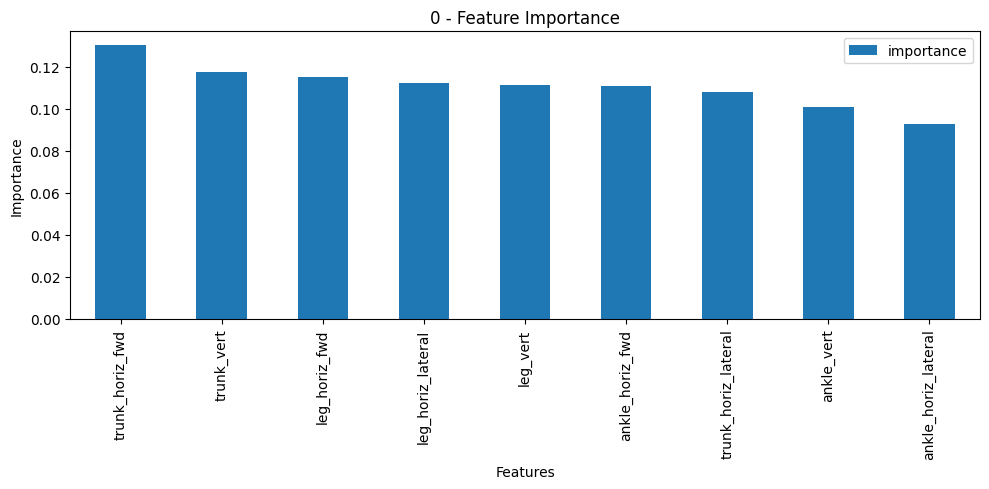

-----------------------------------------------------------------------------------------------




importances [0.08436376 0.07502178 0.08740278 0.11268435 0.20994262 0.10848532
 0.09229008 0.06590986 0.16389946] 1
important_features ['leg_vert', 'trunk_horiz_lateral', 'leg_horiz_fwd', 'leg_horiz_lateral', 'trunk_horiz_fwd']
X_train_class [[ 870   48  390  353 -359]
 [ 842  -48  445  393 -320]
 [ 851   48  581  404 -349]
 ...
 [1018   87    0  141    9]
 [ 962   97   54  181    0]
 [ 953   48  200  161  -29]]
Shape of X_train_class: (8412, 5)
y_train_class 8412     0
8413     0
8414     0
8415     0
8416     0
        ..
16819    0
16820    0
16821    0
16822    0
16823    0
Name: is_anomaly, Length: 8412, dtype: int64
1 importance list:
1 
                      importance
Features                       
leg_vert               0.209943
trunk_horiz_lateral    0.163899
leg_horiz_fwd          0.112684
leg_horiz_lateral      0.108485
trunk_horiz_fwd        0.092290
ankle_horiz_lateral    

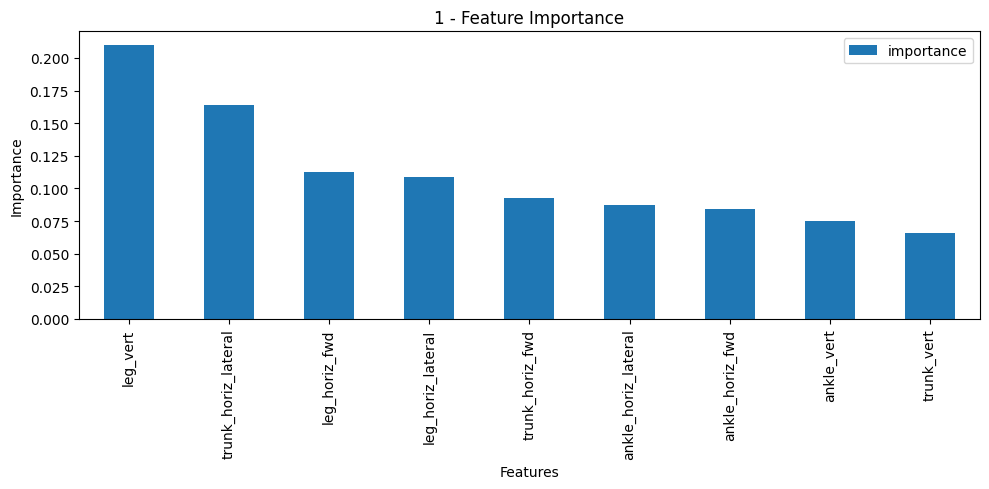

-----------------------------------------------------------------------------------------------




importances [0.11724066 0.09357034 0.10068299 0.14300033 0.10734131 0.08585214
 0.11767103 0.102003   0.1326382 ] 2
important_features ['leg_horiz_fwd', 'trunk_horiz_lateral', 'trunk_horiz_fwd', 'ankle_horiz_fwd', 'leg_vert']
X_train_class [[  218    48   -29  -121   953]
 [  172    77   -38  -131   944]
 [  154    87   -48  -131   953]
 ...
 [  663   252    -9 -1303  1222]
 [  545   233   -67 -1787  1574]
 [  545   242  -126 -1808  1574]]
Shape of X_train_class: (8412, 5)
y_train_class 16824    0
16825    0
16826    0
16827    0
16828    0
        ..
25231    0
25232    0
25233    0
25234    0
25235    0
Name: is_anomaly, Length: 8412, dtype: int64
2 importance list:
2 
                      importance
Features                       
leg_horiz_fwd          0.143000
trunk_horiz_lateral    0.132638
trunk_horiz_fwd        0.117671
ankle_horiz_fwd        0.117241
leg_vert               0.10

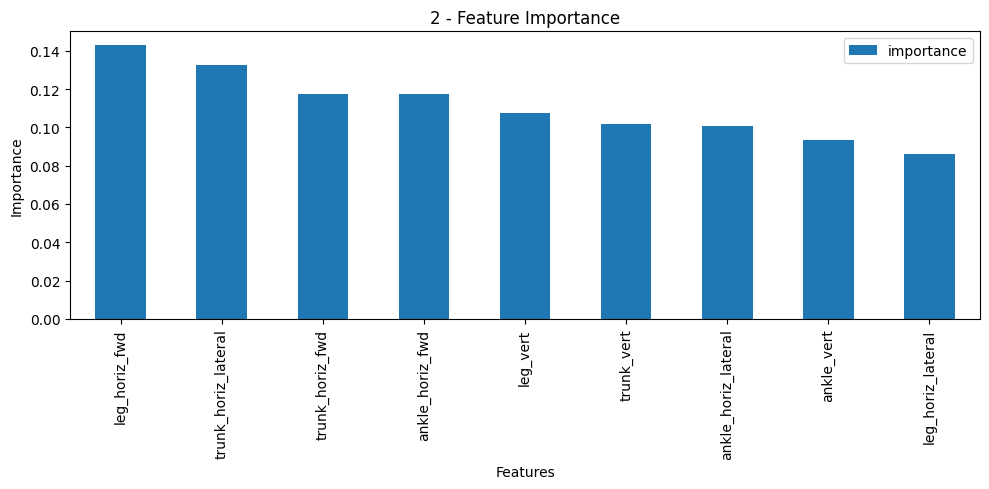

-----------------------------------------------------------------------------------------------




importances [0. 0. 0. 0. 0. 0. 0. 0. 0.] 3
important_features ['ankle_horiz_fwd', 'ankle_vert', 'ankle_horiz_lateral', 'leg_horiz_fwd', 'leg_vert']
X_train_class [[-1939  1205   831   272  1157]
 [-4616  2039  -841   509  1138]
 [  858  4725 -4524  2500  2000]
 ...
 [ -333   980   356  -345  1027]
 [ -434   970   356  -509  1009]
 [ -434  1009   346  -536  1027]]
Shape of X_train_class: (8411, 5)
y_train_class 25236    0
25237    0
25238    0
25239    0
25240    0
        ..
33642    0
33643    0
33644    0
33645    0
33646    0
Name: is_anomaly, Length: 8411, dtype: int64
3 importance list:
3 
                      importance
Features                       
ankle_horiz_fwd             0.0
ankle_vert                  0.0
ankle_horiz_lateral         0.0
leg_horiz_fwd               0.0
leg_vert                    0.0
leg_horiz_lateral           0.0
trunk_horiz_fwd             0.0
trunk_ver

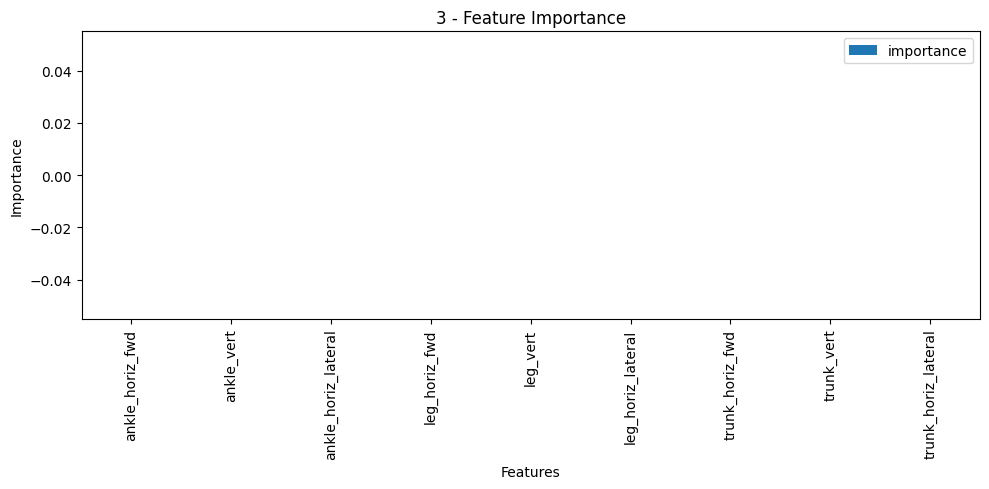

-----------------------------------------------------------------------------------------------




importances [0.11521541 0.10856768 0.10643838 0.13451793 0.09274973 0.11020067
 0.11659062 0.11271913 0.10300047] 4
important_features ['leg_horiz_fwd', 'trunk_horiz_fwd', 'ankle_horiz_fwd', 'trunk_vert', 'leg_horiz_lateral']
X_train_class [[-200    9 -323  866  222]
 [  90    0 -232  933  181]
 [ 372  -38   80  942  121]
 ...
 [ 872   38  -10  971  212]
 [ 881   29  -20  971  202]
 [ 881   29  -30  971  202]]
Shape of X_train_class: (8411, 5)
y_train_class 33647    0
33648    0
33649    0
33650    0
33651    0
        ..
42053    0
42054    0
42055    0
42056    0
42057    0
Name: is_anomaly, Length: 8411, dtype: int64
4 importance list:
4 
                      importance
Features                       
leg_horiz_fwd          0.134518
trunk_horiz_fwd        0.116591
ankle_horiz_fwd        0.115215
trunk_vert             0.112719
leg_horiz_lateral      0.110201
ankle_vert             0.

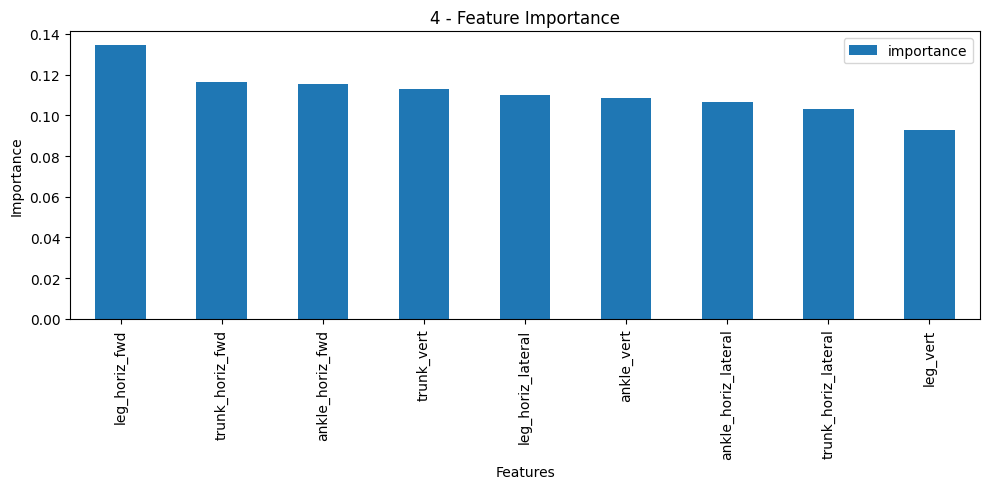

-----------------------------------------------------------------------------------------------




importances [0.10323858 0.09487556 0.09019996 0.10564787 0.21229495 0.09334855
 0.10761441 0.09972025 0.09305987] 5
important_features ['leg_vert', 'trunk_horiz_fwd', 'leg_horiz_fwd', 'ankle_horiz_fwd', 'trunk_vert']
X_train_class [[ 259   48  872  -10  971]
 [ 250   48  881  -20  980]
 [ 259   38  881  -20  971]
 ...
 [ 879  -87   27 -252  952]
 [ 879  -19 -172 -313  961]
 [ 953   58 -245 -393  952]]
Shape of X_train_class: (8411, 5)
y_train_class 42058    0
42059    0
42060    0
42061    0
42062    0
        ..
50464    0
50465    0
50466    0
50467    0
50468    0
Name: is_anomaly, Length: 8411, dtype: int64
5 importance list:
5 
                      importance
Features                       
leg_vert               0.212295
trunk_horiz_fwd        0.107614
leg_horiz_fwd          0.105648
ankle_horiz_fwd        0.103239
trunk_vert             0.099720
ankle_vert             0.094876
le

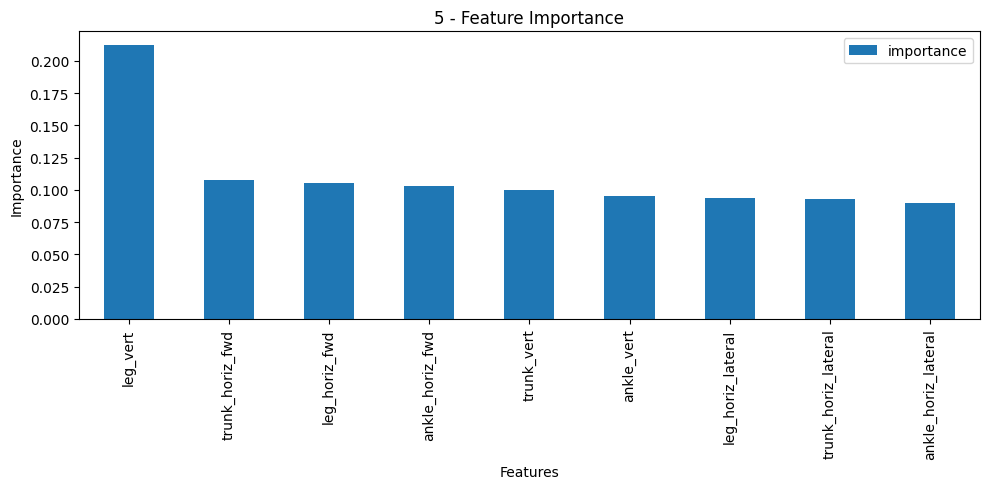

-----------------------------------------------------------------------------------------------




importances [0.05529696 0.04930845 0.0605152  0.0747562  0.51561046 0.04787899
 0.06303015 0.05789743 0.07570616] 6
important_features ['leg_vert', 'trunk_horiz_lateral', 'leg_horiz_fwd', 'trunk_horiz_fwd', 'ankle_horiz_lateral']
X_train_class [[ 935  184 -209  106  396]
 [ 916  145 -145  135  465]
 [ 935   97  -63  155  504]
 ...
 [ 240  281  872  135  326]
 [ 250  291  854  135  316]
 [ 259  291  854  135  356]]
Shape of X_train_class: (8411, 5)
y_train_class 50469    0
50470    0
50471    0
50472    0
50473    0
        ..
58875    0
58876    0
58877    0
58878    0
58879    0
Name: is_anomaly, Length: 8411, dtype: int64
6 importance list:
6 
                      importance
Features                       
leg_vert               0.515610
trunk_horiz_lateral    0.075706
leg_horiz_fwd          0.074756
trunk_horiz_fwd        0.063030
ankle_horiz_lateral    0.060515
trunk_vert           

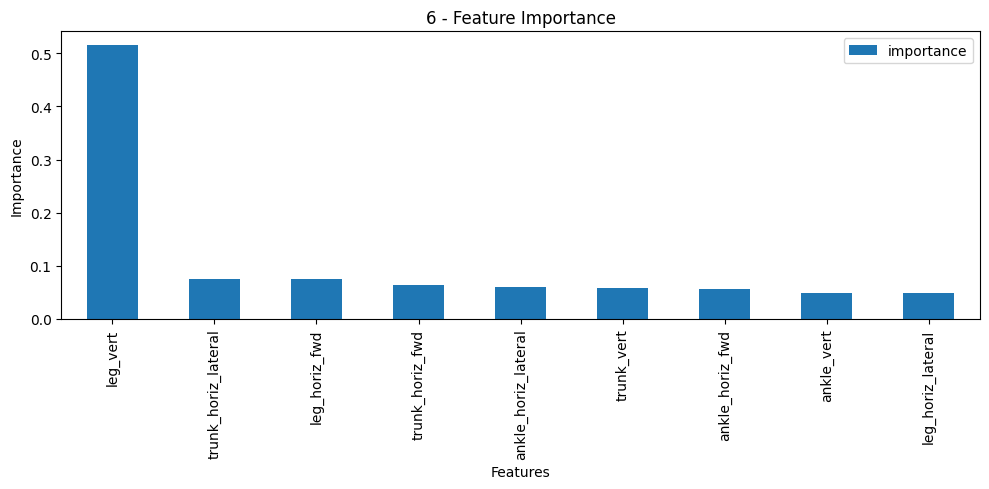

-----------------------------------------------------------------------------------------------




feature_importances {0: ['trunk_horiz_fwd', 'trunk_vert', 'leg_horiz_fwd', 'leg_horiz_lateral', 'leg_vert'], 1: ['leg_vert', 'trunk_horiz_lateral', 'leg_horiz_fwd', 'leg_horiz_lateral', 'trunk_horiz_fwd'], 2: ['leg_horiz_fwd', 'trunk_horiz_lateral', 'trunk_horiz_fwd', 'ankle_horiz_fwd', 'leg_vert'], 3: ['ankle_horiz_fwd', 'ankle_vert', 'ankle_horiz_lateral', 'leg_horiz_fwd', 'leg_vert'], 4: ['leg_horiz_fwd', 'trunk_horiz_fwd', 'ankle_horiz_fwd', 'trunk_vert', 'leg_horiz_lateral'], 5: ['leg_vert', 'trunk_horiz_fwd', 'leg_horiz_fwd', 'ankle_horiz_fwd', 'trunk_vert'], 6: ['leg_vert', 'trunk_horiz_lateral', 'leg_horiz_fwd', 'trunk_horiz_fwd', 'ankle_horiz_lateral']}
mission accomplished!
Total operation time: =  60.93586277961731 seconds


In [63]:
seconds = time.time()

ths = open("importance_list.csv", "w")
feature_importances = {}
SVMs = {}

for i, (X_set, y_set) in enumerate(zip(X_train_sets, y_train_sets)):
    #computing the feature importances
    forest = sk.ensemble.RandomForestRegressor(n_estimators=250,random_state=0)
    forest.fit(X_set, y_set)
    importances = forest.feature_importances_
    print('importances', importances, i)
    std = np.std([tree.feature_importances_ for tree in forest.estimators_],
                 axis=0)
    indices = np.argsort(importances)[::-1]
    num_features = len(importances)
    num_display = min(num_features, 20)  # Only display up to the maximum available features
    refclasscol=list(df.columns.values)
    impor_bars = pd.DataFrame({'Features':refclasscol[0:num_display],'importance':importances[0:num_display]})
    impor_bars = impor_bars.sort_values('importance',ascending=False)
    important_features = impor_bars['Features'].to_list()[:5]
    impor_bars = impor_bars.set_index('Features')
    print('important_features', important_features)
    feature_importances[i] = important_features
    
    svm = OCSVMSKI()
    X_train_class = np.array(X_set.iloc[:, X_set.columns.get_indexer(important_features)])
    print('X_train_class', X_train_class)
    if isinstance(X_train_class, np.ndarray):
        print("Shape of X_train_class:", X_train_class.shape)
    else:
        print("X_train_class is not a numpy array.")
    y_train_class = y_set
    print('y_train_class', y_train_class)
    if len(y_train_class) > 0:  # Ensure there are samples for this class
        svm.fit(X_train_class)
    else:
        print(f'no data for {i}')
    SVMs[i] = svm
    
    plt.rcParams['figure.figsize'] = (10, 5)
    impor_bars.plot.bar();
    #printing the feature importances  
    count=0
    fea_ture=str(i)+"=["
    for j in impor_bars.index:
        fea_ture=fea_ture+"\""+str(j)+"\","
        count+=1
        if count==5:
            fea_ture=fea_ture[0:-1]+"]"
            break     
    print(i,"importance list:")
    print(i,"\n",impor_bars.head(20),"\n\n\n")
    print(fea_ture)
    plt.title(str(i)+" - Feature Importance")
    plt.ylabel('Importance')
    plt.savefig(os.path.join(feature_folder, str(i)+".pdf"),bbox_inches='tight', format = 'pdf')
    ths.write((  fea_ture ) )
    plt.tight_layout()
    plt.show()
    print("-----------------------------------------------------------------------------------------------\n\n\n\n")

print('feature_importances', feature_importances)
print("mission accomplished!")
print("Total operation time: = ",time.time()- seconds ,"seconds")
ths.close()



In [68]:
# TEST_COUNT = 100

# Step 1: Train KNN to classify
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train, set_numbers)

# Step 2: Predict classes for the test set
knn_predictions = knn.predict(np.array(X_test))
print('knn_predictions', knn_predictions)

knn_predictions [6 6 6 ... 1 1 1]


In [69]:
# y_test = y_test[:TEST_COUNT]
# print("KNN Evaluation:")
# print("Confusion Matrix:")
# print(confusion_matrix(y_test, knn_predictions))
# print(confusion_matrix(y_test, knn_predictions))
# print("\nClassification Report:")
# print(classification_report(y_test, knn_predictions))
# print("Accuracy:", accuracy_score(y_test, knn_predictions))

In [71]:
svm_predictions = []

for i in range(X_test.shape[0]):
    # test_instance = X_test.iloc[i]
    predicted_label = knn_predictions[i]
    # print('predicted_label', predicted_label)
    selected_features = feature_importances[predicted_label]
    # print('selected_features', selected_features)
    svm_model = SVMs[predicted_label]
    
    test_instance_selected = X_test.iloc[i, X.columns.get_indexer(selected_features)].values.reshape(1, -1)
    # print('test_instance_selected', test_instance_selected)
    
    svm_prediction = svm_model.predict(np.array(test_instance_selected))
    # print(svm_prediction)
    svm_predictions.append(svm_prediction)

In [72]:
# print("y_true:", y_test.values)
svm_predictions_flattened = np.array([pred[0, 0] for pred in svm_predictions])
# print("y_pred:", svm_predictions_flattened)

print("Confusion Matrix:")
print(confusion_matrix(y_test.values, svm_predictions_flattened))
print("\nClassification Report:")
print(classification_report(y_test.values, svm_predictions_flattened))
print("Accuracy:", accuracy_score(y_test.values, svm_predictions_flattened))

# Optionally, you can also compute the overall accuracy
# overall_accuracy = accuracy_score(y_test, np.concatenate((svm_predictions, knn_predictions[~anomaly_mask])))
# print("\nOverall Accuracy:", overall_accuracy)

Confusion Matrix:
[[  459 13971]
 [    0   290]]

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.03      0.06     14430
           1       0.02      1.00      0.04       290

    accuracy                           0.05     14720
   macro avg       0.51      0.52      0.05     14720
weighted avg       0.98      0.05      0.06     14720

Accuracy: 0.050883152173913045
